In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import matplotlib.pyplot as plt

from os.path import join

from scipy.stats import fligner
from nilearn import plotting, datasets, surface

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
sns.set(style='whitegrid', context='talk')
plt.rcParams["font.family"] = "monospace"
plt.rcParams['font.monospace'] = 'Courier New'

In [3]:
crayons = sns.crayon_palette(['Aquamarine', 'Fuchsia', 
                              'Jungle Green', 'Fern'])

In [4]:
PROJ_DIR = "/Volumes/projects_herting/LABDOCS/Personnel/Katie/deltaABCD_clustering/"
DATA_DIR = "data/"
FIGS_DIR = "figures/"
OUTP_DIR = "output/"

In [5]:
df = pd.read_csv(join(PROJ_DIR, DATA_DIR, "data_qcd.csv"), index_col=0, header=0)

In [6]:
df.drop(list(df.filter(regex='lesion.*').columns), axis=1, inplace=True)
df.drop(list(df.filter(regex='.*_cf12_.*').columns), axis=1, inplace=True)
no_2yfu = df[df["interview_date.2_year_follow_up_y_arm_1"].isna() == True].index
df = df.drop(no_2yfu, axis=0)

In [37]:
df.columns

Index(['mrirsfd112.baseline_year_1_arm_1', 'mrirsfd9.baseline_year_1_arm_1',
       'mrirsfd107.2_year_follow_up_y_arm_1',
       'mrirsfd103.baseline_year_1_arm_1', 'mrirsfd4.2_year_follow_up_y_arm_1',
       'mrirsfd47.change_score', 'mrirsfd115.change_score',
       'mrirsfd2.change_score', 'mrirsfd145.2_year_follow_up_y_arm_1',
       'mrirsfd97.2_year_follow_up_y_arm_1',
       ...
       'dmri_rsirndgm_cdx_stsrh.baseline_year_1_arm_1',
       'dmri_rsirndgm_cdx_stsrh.2_year_follow_up_y_arm_1',
       'dmri_rsirndgm_cdx_stsrh.change_score',
       'dmri_rsirndgm_cdx_sttrh.baseline_year_1_arm_1',
       'dmri_rsirndgm_cdx_sttrh.2_year_follow_up_y_arm_1',
       'dmri_rsirndgm_cdx_sttrh.change_score',
       'dmri_rsirndgm_cdx_mean.baseline_year_1_arm_1',
       'dmri_rsirndgm_cdx_mean.2_year_follow_up_y_arm_1',
       'dmri_rsirndgm_cdx_mean.change_score',
       'pds_p_ss_category_2.baseline_year_1_arm_1'],
      dtype='object', length=7698)

In [7]:
deltasmri_complete = pd.concat([df.filter(regex='smri.*change_score'), 
                                df.filter(regex='mrisdp.*change_score')], axis=1).dropna()
deltarsfmri_complete = df.filter(regex='rsfmri.*change_score').dropna(how='any')
deltarsi_complete = df.filter(regex='dmri_rsi.*change_score').dropna()
deltadti_complete = df.filter(regex='dmri_dti.*change_score').dropna()

In [8]:
img_modalities = {'smri': deltasmri_complete,
                  'fmri': deltarsfmri_complete,
                  'rsi': deltarsi_complete, 
                  'dti': deltadti_complete}

In [9]:
tests = ['variance', 
         'fligner_sex',
         'fligner_puberty',
         'fligner_raceth', 
         'fligner_income', 
         'fligner_edu', 
         'fligner_marital', 
         'fligner_age', 
         #'fligner_scanner'
        ]

In [10]:
alpha = 0.05
values = ['stat', 'p', 'diff', 'greater', f'a<{alpha}']
columns = pd.MultiIndex.from_product([tests, values])

var_df = pd.DataFrame(columns=columns)

In [11]:
age_bins = np.zeros((9,))
ages = df['interview_age.baseline_year_1_arm_1'].sort_values().unique()

i = 0
j = 0
while j < 27.:
    age_bins[i] = ages[j]
    i += 1
    j += 3

/var/folders/t5/4bz0680d45n5_5m30ny85m540000gp/T/ipykernel_3142/3026442557.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  age_hist = pd.Series()
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

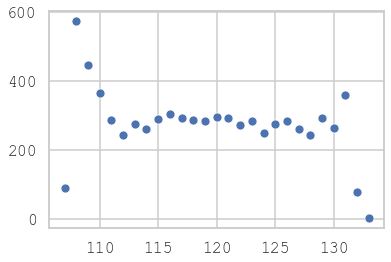

In [12]:
age_hist = pd.Series()
for age in ages:
    age_hist.at[age] =  len(df[df['interview_age.baseline_year_1_arm_1'] == age].index)
sns.scatterplot(age_hist.index, age_hist.values)

In [13]:
df[['pds_p_ss_female_category_2.baseline_year_1_arm_1',
    'pds_p_ss_male_category_2.baseline_year_1_arm_1']]
df['pds_p_ss_category_2.baseline_year_1_arm_1'] = df['pds_p_ss_female_category_2.baseline_year_1_arm_1'].fillna(0) + df['pds_p_ss_male_category_2.baseline_year_1_arm_1'].fillna(0)


In [14]:

# check group sizes
m = df[df['sex.baseline_year_1_arm_1'] == 'M'].index
f = df[df['sex.baseline_year_1_arm_1'] == 'F'].index
print('sex\n', f'f:\t{len(f)}')

puberty = 'pds_p_ss_category_2.baseline_year_1_arm_1'
one = df[df[puberty] == 1.].index
two = df[df[puberty] == 2.].index
three = df[df[puberty] == 3.].index
print('puberty\n'
              f'1:\t{len(one)}\n2:\t{len(two)}\n3:\t{len(three)}')

race = 'race_ethnicity.baseline_year_1_arm_1'
white = df[df[race] == 1.].index
black = df[df[race] == 2.].index
hispanic = df[df[race] == 3.].index
asian = df[df[race] == 4.].index
other = df[df[race] == 5.].index
print('\nrace\n',len(white), len(black), len(hispanic), len(asian) + len(other))

income = 'demo_comb_income_v2.baseline_year_1_arm_1'
lt75k = len(df[df[income] < 7.].index)
lt100 = len(df[df[income].between(7., 8.)].index)
gt100 = len(df[df[income].between(9., 10.)].index)
print('\nincome\n',lt75k, lt100, gt100)

edu = 'demo_prnt_ed_v2.baseline_year_1_arm_1'
one = len(df[df[edu] == 1].index)
two = len(df[df[edu] == 2].index)
three = len(df[df[edu] == 3].index)
four = len(df[df[edu] == 4].index)
five = len(df[df[edu] == 5].index)
six = len(df[df[edu] == 6].index)
seven = len(df[df[edu] == 7].index)
eight = len(df[df[edu] == 8].index)
nine = len(df[df[edu] == 9].index)
ten = len(df[df[edu] == 10].index)
eleven = len(df[df[edu] == 11].index)
twelve = len(df[df[edu] == 12].index)
thirteen = len(df[df[edu] == 13].index)
fourteen = len(df[df[edu] == 14].index)
fifteen = len(df[df[edu] == 15].index)
sixteen = len(df[df[edu] == 16].index)
seventeen = len(df[df[edu] == 17].index)
eighteen = len(df[df[edu] == 18].index)
nineteen = len(df[df[edu] == 19].index)
twenty = len(df[df[edu] == 20].index)
twentyone = len(df[df[edu] == 21].index)
print('\neducation\n', one, two, three, four, five, six, 
                      seven, eight, nine, ten, #sevens, 
                      eleven, twelve, thirteen, fourteen, fifteen,
                      sixteen, seventeen, eighteen, nineteen, twenty, twentyone)
lt_hs = len(df[df[edu] < 12].index)
hs_ged = len(df[df[edu].between(13, 14)].index)
college = len(df[df[edu] == 15].index)
aa_deg = len(df[df[edu].between(16, 17)].index)
bachelors = len(df[df[edu] == 18].index)
graduate = len(df[df[edu].between(19, 22)].index)
print(lt_hs + hs_ged, college + aa_deg, bachelors, graduate)

age = 'interview_age.baseline_year_1_arm_1'
one = len(df[df[age] < age_bins[1]].index)
two = len(df[df[age].between(age_bins[1], age_bins[2], inclusive='left')].index)
three = len(df[df[age].between(age_bins[2], age_bins[3], inclusive='left')].index)
four = len(df[df[age].between(age_bins[3], age_bins[4], inclusive='left')].index)
five = len(df[df[age].between(age_bins[4], age_bins[5], inclusive='left')].index)
six = len(df[df[age].between(age_bins[5], age_bins[6], inclusive='left')].index)
seven = len(df[df[age].between(age_bins[6], age_bins[7], inclusive='left')].index)
eight = len(df[df[age].between(age_bins[7], age_bins[8], inclusive='left')].index)
#nine = len(df[df[age].between(age_bins[8], age_bins[9] - 1.)].index)
ten = len(df[df[age] >= age_bins[8]].index)
print('\nage\n',one, two, three, four, five, six, 
                      seven, eight, #nine, 
      ten)

#marital status
marry = "demo_prnt_marital_v2.baseline_year_1_arm_1"
married = len(df[df[marry] == 1.].index)
widowed = len(df[df[marry] == 2.].index)
divorced = len(df[df[marry] == 3.].index)
separated = len(df[df[marry] == 4.].index)
never = len(df[df[marry] == 5.].index)
refuse = len(df[df[marry] == 777.].index)
print('\nmarital\n', married, widowed + divorced + separated + never)

sex
 f:	3437
puberty
1:	3874
2:	1675
3:	1562

race
 4108 981 1450 918

income
 1922 2082 2876

education
 2 1 4 2 1 33 14 31 83 61 106 101 562 146 1250 542 441 2204 1442 202 219
1046 2233 2204 1863

age
 1110 894 823 882 871 807 819 796 436

marital
 5192 1831


In [32]:
df[]

NameError: name 'atlases' is not defined

In [15]:
for modality in img_modalities.keys():
    variables = img_modalities[modality].columns
    for var in variables:
        # compute variance across the sample
        var_df.at[var, ('variance', 'stat')] = np.var(df[var])
        
        # compare variance between male and female participants
        m = df[df['sex.baseline_year_1_arm_1'] == 'M'][var].dropna()
        f = df[df['sex.baseline_year_1_arm_1'] == 'F'][var].dropna()
        test = fligner(m, f)
        var_df.at[var, ('fligner_sex', 'stat')] = test[0]
        var_df.at[var, ('fligner_sex', 'p')] = test[1]
        var_df.at[var, ('fligner_sex', 'diff')] = np.mean(f) - np.mean(m)
        var_df.at[var, ('fligner_sex', 'greater')] = 'f'
        if test[1] < alpha:
            var_df.at[var, ('fligner_sex', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_sex', f'a<{alpha}')] = 'ns'
        
        # compare variance between pubertal stages at baseline, female ppts
        puberty = 'pds_p_ss_category_2.baseline_year_1_arm_1'
        one = df[df[puberty] == 1.][var].dropna()
        two = df[df[puberty] == 2.][var].dropna()
        three = df[df[puberty] == 3.][var].dropna()
        
        test = fligner(one, two, three)
        var_df.at[var, ('fligner_puberty', 'stat')] = test[0]
        var_df.at[var, ('fligner_puberty', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_puberty', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_puberty', f'a<{alpha}')] = 'ns'
        
        var_dict = {'1': np.mean(one), 
                    '2': np.mean(two), 
                    '3': np.mean(three)}
        max_key = max(var_dict, key=var_dict.get)
        min_val = min(var_dict.values())
        sorted_keys = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}
        var_df.at[var, ('fligner_puberty', 'diff')] = var_dict[max_key] - min_val
        var_df.at[var, ('fligner_puberty', 'greater')] = [list(sorted_keys.keys())]
        
        # compare variance between pubertal stages at baseline, male ppts
        #puberty = 'pds_p_ss_male_category_2.baseline_year_1_arm_1'
        #one = df[df[puberty] == 1.][var].dropna()
        #two = df[df[puberty] == 2.][var].dropna()
        #three = df[df[puberty] == 3.][var].dropna()
        
        #test = fligner(one, two, three)
        #var_dict = {'1': np.mean(one), 
        #            '2': np.mean(two), 
        #            '3': np.mean(three)}
        #max_key = max(var_dict, key=var_dict.get)
        #min_val = min(var_dict.values())
        #sorted_keys = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}
        #var_df.at[var, ('fligner_puberty_m', 'diff')] = var_dict[max_key] - min_val
        #var_df.at[var, ('fligner_puberty_m', 'greater')] = [list(sorted_keys.keys())]
        #var_df.at[var, ('fligner_puberty_m', 'stat')] = test[0]
        #var_df.at[var, ('fligner_puberty_m', 'p')] = test[1]
        #if test[1] < alpha:
        #    var_df.at[var, ('fligner_puberty_m', f'a<{alpha}')] = '**'
        #else:
        #    var_df.at[var, ('fligner_puberty_m', f'a<{alpha}')] = 'ns'
        
        # compare variance between sexes at baseline, pubertal stages
        #puberty_f = 'pds_p_ss_female_category_2.baseline_year_1_arm_1'
        #puberty_m = 'pds_p_ss_male_category_2.baseline_year_1_arm_1'
        #one_f = df[df[puberty_f] == 1.][var].dropna()
        #two_f = df[df[puberty_f] == 2.][var].dropna()
        #three_f = df[df[puberty_f] == 3.][var].dropna()
        #one_m = df[df[puberty_m] == 1.][var].dropna()
        #two_m = df[df[puberty_m] == 2.][var].dropna()
        #three_m = df[df[puberty_m] == 3.][var].dropna()
        #test = fligner(one_f, one_m)
        
        #var_df.at[var, ('fligner_puberty_1', 'stat')] = test[0]
        #var_df.at[var, ('fligner_puberty_1', 'p')] = test[1]
        #var_df.at[var, ('fligner_puberty_1', 'diff')] = np.mean(one_f) - np.mean(one_m)
        #var_df.at[var, ('fligner_puberty_1', 'greater')] = 'f'
        #if test[1] < alpha:
        #    var_df.at[var, ('fligner_puberty_1', f'a<{alpha}')] = '**'
        #else:
        #    var_df.at[var, ('fligner_puberty_1', f'a<{alpha}')] = 'ns'
        #test = fligner(two_f, two_m)
        #var_df.at[var, ('fligner_puberty_2', 'stat')] = test[0]
        #var_df.at[var, ('fligner_puberty_2', 'p')] = test[1]
        #var_df.at[var, ('fligner_puberty_2', 'diff')] = np.mean(two_f) - np.mean(two_m)
        #var_df.at[var, ('fligner_puberty_2', 'greater')] = 'f'
        #if test[1] < alpha:
        #    var_df.at[var, ('fligner_puberty_2', f'a<{alpha}')] = '**'
        #else:
        #    var_df.at[var, ('fligner_puberty_2', f'a<{alpha}')] = 'ns'
        #test = fligner(three_f, three_m)
        #var_df.at[var, ('fligner_puberty_3', 'stat')] = test[0]
        #var_df.at[var, ('fligner_puberty_3', 'p')] = test[1]
        #var_df.at[var, ('fligner_puberty_3', 'diff')] = np.mean(three_f) - np.mean(three_m)
        #var_df.at[var, ('fligner_puberty_3', 'greater')] = 'f'
        #if test[1] < alpha:
        #    var_df.at[var, ('fligner_puberty_3', f'a<{alpha}')] = '**'
        #else:
        #    var_df.at[var, ('fligner_puberty_3', f'a<{alpha}')] = 'ns'
        
        #compare variance across race/ethnicities
        race = 'race_ethnicity.baseline_year_1_arm_1'
        white = df[df[race] == 1.][var].dropna()
        black = df[df[race] == 2.][var].dropna()
        hispanic = df[df[race] == 3.][var].dropna()
        asian = df[df[race] == 4.][var].dropna()
        other = df[df[race] == 5.][var].dropna()
        asian_other = df[df[race].between(4., 5.)][var].dropna()
        test = fligner(white, black, hispanic, asian_other)
        var_df.at[var, ('fligner_raceth', 'stat')] = test[0]
        var_df.at[var, ('fligner_raceth', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_raceth', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_raceth', f'a<{alpha}')] = 'ns'
        
        # compare variance across income
        income = 'demo_comb_income_v2.baseline_year_1_arm_1'
        lt75k = df[df[income] < 7.][var].dropna()
        lt100 = df[df[income].between(7., 8.)][var].dropna()
        gt100 = df[df[income].between(9., 10.)][var].dropna()
        
        test = fligner(lt75k, lt100, gt100)
        var_df.at[var, ('fligner_income', 'stat')] = test[0]
        var_df.at[var, ('fligner_income', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_income', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_income', f'a<{alpha}')] = 'ns'
        
        # compare variance across education
        edu = 'demo_prnt_ed_v2.baseline_year_1_arm_1'
        hs_ged = df[df[edu] <= 14][var].dropna()
        #hs_ged = df[df[edu].between(13, 14)][var].dropna()
        #college = df[df[edu] == 15][var].dropna()
        lt_4yuni = df[df[edu].between(15, 17)][var].dropna()
        bachelors = df[df[edu] == 18][var].dropna()
        graduate = df[df[edu].between(19, 22)][var].dropna()
        
        test = fligner(hs_ged, lt_4yuni, bachelors, graduate)
        var_df.at[var, ('fligner_edu', 'stat')] = test[0]
        var_df.at[var, ('fligner_edu', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_edu', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_edu', f'a<{alpha}')] = 'ns'
        
        # compare variance across age, binned by n0th percentiles
        # age_bins are calculated above
        age = 'interview_age.baseline_year_1_arm_1'
        one = df[df[age] <= age_bins[1]][var].dropna()
        two = df[df[age].between(age_bins[1], age_bins[2], inclusive='left')][var].dropna()
        three = df[df[age].between(age_bins[2], age_bins[3], inclusive='left')][var].dropna()
        four = df[df[age].between(age_bins[3], age_bins[4], inclusive='left')][var].dropna()
        five = df[df[age].between(age_bins[4], age_bins[5], inclusive='left')][var].dropna()
        six = df[df[age].between(age_bins[5], age_bins[6], inclusive='left')][var].dropna()
        seven = df[df[age].between(age_bins[6], age_bins[7], inclusive='left')][var].dropna()
        eight = df[df[age].between(age_bins[7], age_bins[8], inclusive='left')][var].dropna()
        #nine = df[df[age].between(age_bins[8], age_bins[9], inclusive='left')][var].dropna()
        ten = df[df[age] >= age_bins[8]][var].dropna()
                 
        test = fligner(one, two, three, four, five, six, 
                      seven, eight, #nine, 
                       ten)
        var_df.at[var, ('fligner_age', 'stat')] = test[0]
        var_df.at[var, ('fligner_age', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_age', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_age', f'a<{alpha}')] = 'ns'
        
         # compare variance across scanner manufacturers
        mri = 'mri_info_manufacturer.baseline_year_1_arm_1'
        siemens = df[df[mri] == 'SIEMENS'][var].dropna()
        ge = df[df[mri] == 'GE MEDICAL SYSTEMS'][var].dropna()
        philips = df[df[mri] == 'Philips Medical Systems'][var].dropna()
        
        test = fligner(siemens, philips, ge)
        var_df.at[var, ('fligner_scanner', 'stat')] = test[0]
        var_df.at[var, ('fligner_scanner', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_scanner', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_scanner', f'a<{alpha}')] = 'ns'
        
        # compare variance across parent marital status
        marry = "demo_prnt_marital_v2.baseline_year_1_arm_1"
        married = df[df[marry] == 1.][var].dropna()
        notmarried = df[df[marry].between(2,5)][var].dropna()
        widowed = df[df[marry] == 2.][var].dropna()
        divorced = df[df[marry] == 3.][var].dropna()
        separated = df[df[marry] == 4.][var].dropna()
        never = df[df[marry] == 5.][var].dropna()
        refuse = df[df[marry] == 777.][var].dropna()
        
        test = fligner(married, notmarried
                       #widowed, 
                       #separated, 
                       #divorced, 
                       #never, 
                       #refuse
                      )
        var_df.at[var, ('fligner_marital', 'stat')] = test[0]
        var_df.at[var, ('fligner_marital', 'p')] = test[1]
        if test[1] < alpha:
            var_df.at[var, ('fligner_marital', f'a<{alpha}')] = '**'
        else:
            var_df.at[var, ('fligner_marital', f'a<{alpha}')] = 'ns'

In [16]:
var_df.dropna(how='all', axis=1, inplace=True)

In [19]:

var_df.to_csv(join(PROJ_DIR, 
                   #'..',
                   OUTP_DIR, 
                   'variance_flinger.csv'))

In [20]:

var_df = pd.read_csv(join(PROJ_DIR, 
                   #'..',
                   OUTP_DIR, 
                   'variance_flinger.csv'), index_col=0, header=[0,1])

In [21]:
concepts = {'morph': ['thick', 
                      'area', 
                      'vol',
                      'gmvol',
                      'dtivol'],
            'cell': ['t1wcnt', 
                     'rsirni', 
                     'rsirnd',
                     'rsirnigm', 
                     'rsirndgm',
                     'dtifa', 
                     'dtimd'],
            'func':['var',
                    'c',
                     'cor']}

In [22]:
var_df

variance fligner_sex  \
                                                 stat        stat   
smri_vol_scs_intracranialv.change_score      1.572152   31.455710   
smri_vol_cdk_total.change_score              1.193721   28.320622   
smri_area_cdk_banksstslh.change_score        7.740116    1.834034   
smri_area_cdk_cdacatelh.change_score         6.818591    0.284565   
smri_area_cdk_cdmdfrlh.change_score          7.654508    0.006717   
...                                               ...         ...   
dmri_dtivol_fiberat_ifsfcrh.change_score     3.855145    4.304042   
dmri_dtivol_fiberat_ifsfclh.change_score     5.810875   14.878118   
dmri_dtivol_fiberat_fxcutrh.change_score    12.450825    0.968853   
dmri_dtivol_fiberat_fxcutlh.change_score    13.593638    1.641930   
dmri_dtivol_fiberat_allfibers.change_score   2.641975    8.536741   

                                                                            \
                                                       p      diff greater   
smri_vol_scs_intracranialv.change_score     2.040417e-08  0.078135       f   
smri_vol_cdk_total.change_score             1.027950e-07 -0.313021       f   
smri_area_cdk_banksstslh.change_score       1.756518e-01 -0.405665       f   
smri_area_cdk_cdacatelh.change_score        5.937248e-01 -0.156529       f   
smri_area_cdk_cdmdfrlh.change_score         9.346805e-01 -0.255236       f   
...                                                  ...       ...     ...   
dmri_dtivol_fiberat_ifsfcrh.change_score    3.802190e-02  0.269416       f   
dmri_dtivol_fiberat_ifsfclh.change_score    1.146856e-04  0.244456       f   
dmri_dtivol_fiberat_fxcutrh.change_score    3.249664e-01  0.079487       f   
dmri_dtivol_fiberat_fxcutlh.change_score    2.000608e-01  0.070947       f   
dmri_dtivol_fiberat_allfibers.change_score  3.480483e-03  0.124645       f   

                                                  fligner_puberty  \
                                           a<0.05            stat   
smri_vol_scs_intracranialv.change_score        **       74.621559   
smri_vol_cdk_total.change_score                **       85.460153   
smri_area_cdk_banksstslh.change_score          ns        0.169508   
smri_area_cdk_cdacatelh.change_score           ns        4.491108   
smri_area_cdk_cdmdfrlh.change_score            ns        0.253291   
...                                           ...             ...   
dmri_dtivol_fiberat_ifsfcrh.change_score       **       14.044234   
dmri_dtivol_fiberat_ifsfclh.change_score       **       13.251378   
dmri_dtivol_fiberat_fxcutrh.change_score       ns        8.149332   
dmri_dtivol_fiberat_fxcutlh.change_score       ns       24.245929   
dmri_dtivol_fiberat_allfibers.change_score     **       18.672002   

                                                                    \
                                                       p      diff   
smri_vol_scs_intracranialv.change_score     6.253662e-17  0.199255   
smri_vol_cdk_total.change_score             2.770535e-19  0.496429   
smri_area_cdk_banksstslh.change_score       9.187381e-01  0.540712   
smri_area_cdk_cdacatelh.change_score        1.058689e-01  0.286401   
smri_area_cdk_cdmdfrlh.change_score         8.810461e-01  0.383534   
...                                                  ...       ...   
dmri_dtivol_fiberat_ifsfcrh.change_score    8.919352e-04  0.199489   
dmri_dtivol_fiberat_ifsfclh.change_score    1.325867e-03  0.148707   
dmri_dtivol_fiberat_fxcutrh.change_score    1.699789e-02  0.481570   
dmri_dtivol_fiberat_fxcutlh.change_score    5.433298e-06  0.355851   
dmri_dtivol_fiberat_allfibers.change_score  8.819140e-05  0.071854   

                                                               ...  \
                                                      greater  ...   
smri_vol_scs_intracranialv.change_score     [['3', '1', '2']]  ...   
smri_vol_cdk_total.change_score             [['3', '2', '1']]  ...   
smri_area_cdk_banksstslh.change_score      

In [23]:
for var in var_df.index:
    #print(var)
    if 'mrisdp' in var:
        var_num = int(var.split('.')[0].split('_')[-1])
        var_df.at[var, 'modality'] = 'smri'
        var_df.at[var, 'atlas'] = 'dtx'
        if var_num <= 148:
            var_df.at[var, 'measure'] = 'thick'
        elif var_num <= 450 and var_num >= 303:
            var_df.at[var, 'measure'] = 'area'
        elif var_num < 604 and var_num >= 450:
            var_df.at[var, 'measure'] = 'vol'
        elif var_num <= 1054 and var_num >= 907:
            var_df.at[var, 'measure'] = 't1wcnt'
        elif var_num == 604:
            var_df.at[var, 'measure'] = 'gmvol'
    elif '_' in var:
        var_list = var.split('.')[0].split('_')
        var_df.at[var, 'modality'] = var_list[0]
        var_df.at[var, 'measure'] = var_list[1]
        var_df.at[var, 'atlas'] = var_list[2]
        var_df.at[var, 'region'] = '_'.join(var_list[3:])

var_df = var_df[var_df['measure'] != 't1w']
var_df = var_df[var_df['measure'] != 't2w']

In [24]:
for i in var_df.index:
    measure = var_df.loc[i]['measure']
    measure = str(measure.values[0])
    if measure in concepts['morph']:
        var_df.at[i,'concept'] = 'morphology'
    elif measure in concepts['cell']:
        var_df.at[i,'concept'] = 'microstructure'
    elif measure in concepts['func']:
        var_df.at[i,'concept'] = 'function'

In [25]:
# plot the distribution of variances of all structural mri measures
smri_var = img_modalities['smri'].columns
dti_var = img_modalities['dti'].columns
rsi_var = img_modalities['rsi'].columns
fmri_var = img_modalities['fmri'].columns
fmri_cor_var = img_modalities['fmri'].filter(regex='_c.*').columns
fmri_var_var = img_modalities['fmri'].filter(regex='_var_.*').columns

morph_var = var_df[var_df['concept'] == 'morphology'].index
cell_var = var_df[var_df['concept'] == 'microstructure'].index
func_var = fmri_var_var
conn_var = fmri_cor_var

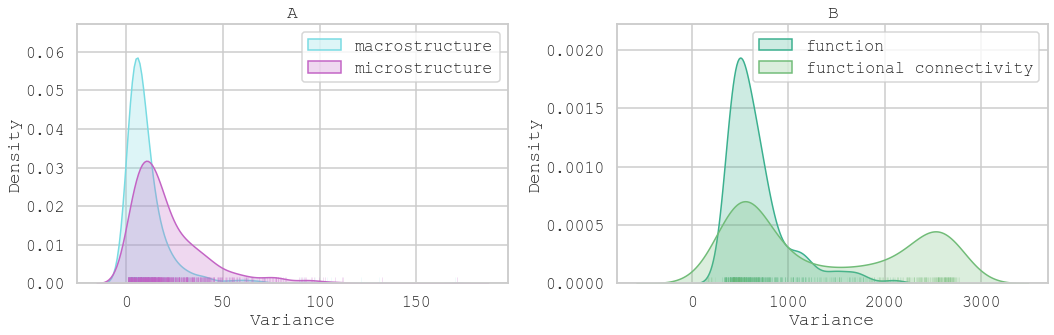

In [27]:
fig,ax = plt.subplots(ncols=2, figsize=(15,5))
g = sns.kdeplot(var_df.loc[morph_var, ('variance', 'stat')], color=crayons[0], shade=True, ax=ax[0])
h = sns.kdeplot(var_df.loc[cell_var, ('variance', 'stat')], color=crayons[1], shade=True, ax=ax[0])
#i = sns.kdeplot(var_df.loc[func_var, ('variance', 'stat')], color=crayons[2], shade=True, ax=ax[0])
#m = sns.kdeplot(var_df.loc[fmri_var, ('variance', 'stat')], color=crayons[3])
j = sns.rugplot(var_df.loc[morph_var, ('variance', 'stat')], color=crayons[0], lw=1, alpha=.1, ax=ax[0])
k = sns.rugplot(var_df.loc[cell_var, ('variance', 'stat')], color=crayons[1], lw=1, alpha=0.2, ax=ax[0])
#l = sns.rugplot(var_df.loc[rsi_var, ('variance', 'stat')], color=crayons[2], lw=1, alpha=.1, ax=ax[0])
#n = sns.rugplot(var_df.loc[fmri_var, ('variance', 'stat')], color=crayons[3])
ax[0].set_xlabel('Variance')
plt.tight_layout()
ax[0].legend(['macrostructure', 
           'microstructure', 
           #'rsi', 
           #'fmri'
          ])
ax[0].set_title('A')

m = sns.kdeplot(var_df.loc[func_var, ('variance', 'stat')], color=crayons[2], shade=True, ax=ax[1])
o = sns.kdeplot(var_df.loc[conn_var, ('variance', 'stat')], color=crayons[3], shade=True, ax=ax[1])
n = sns.rugplot(var_df.loc[func_var, ('variance', 'stat')], color=crayons[2], lw=1, alpha=.1, ax=ax[1])
p = sns.rugplot(var_df.loc[conn_var, ('variance', 'stat')], color=crayons[3], lw=1, alpha=.1, ax=ax[1])
ax[1].set_xlabel('Variance')
plt.tight_layout()
ax[1].legend(['function',
              'functional connectivity'
          ])
ax[1].set_title('B')
fig.savefig('../figures/apchange_variance_concept.png', dpi=400)
#sns.displot(var_df.loc[fmri_var, ('variance', 'stat')])

In [28]:
sex_diff = {}
for modality in img_modalities.keys():
    variables = img_modalities[modality].columns
    sex_diff[modality] = np.sum(var_df.loc[variables][('fligner_sex', 'p')] < 0.01) / len(variables)

In [30]:
print('Proportion of measures from each modality that exhibit significant heteroscasticity with respect to sex:\n',
      sex_diff)

Proportion of measures from each modality that exhibit significant heteroscasticity with respect to sex:
 {'smri': 0.16666666666666666, 'fmri': 0.10236220472440945, 'rsi': 0.04659498207885305, 'dti': 0.08947368421052632}


## Visualizing brain heterogeneity across non-brain variables
1. Variability across all brain measures
2. Per modality
3. Across the brain
4. Across developmental variables
5. Across demographic variables

In [ ]:
for var in var_df.index:
    for modality in img_modalities.keys():
        if var in img_modalities[modality]:
            var_df.at[var, 'modality'] = modality

In [ ]:
var_df[var_df['modality'] == 'fmri'][('variance', 'stat')].sort_values()

In [ ]:
devt = ['fligner_age', 
        'fligner_sex',
        'fligner_puberty']
demo =  ['fligner_raceth',
         'fligner_income',
         'fligner_edu',
         'fligner_marital', 
         #'fligner_scanner'
        ]

In [ ]:
stats = var_df.drop(['variance'], axis=1).xs('stat', level=1, axis=1)
alphas = var_df.xs(f'a<0.05', level=1, axis=1)
modalities = var_df['concept']


In [ ]:
alphas = alphas.add_suffix('_alpha')

In [ ]:
demo_alphas = [f'{i}_alpha' for i in demo]
devt_alphas = [f'{i}_alpha' for i in devt]

In [ ]:
mod_demo = pd.concat([stats[demo], modalities], axis=1).melt(value_vars=demo, 
                                                  value_name='Flinger-Killeen Statistic',
                                                  id_vars='concept').drop('variable', axis=1)
alpha_demo = alphas[demo_alphas].melt(value_name='Significant')
demo_flinger = pd.concat([mod_demo, alpha_demo], axis=1)

mod_devt = pd.concat([stats[devt], modalities], axis=1).melt(value_vars=devt, 
                                                  value_name='Flinger-Killeen Statistic',
                                                  id_vars='concept')
alpha_devt = alphas[devt_alphas].melt(value_name='Significant').drop('variable', axis=1)
devt_flinger = pd.concat([mod_devt, alpha_devt], axis=1)

In [ ]:
mod_devt

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5), squeeze=True)
g = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=devt_flinger[devt_flinger['Significant'] == '**'], 
                  hue='concept',
                  marker='o',
                  size=7,
                  edgecolor='white',
                  dodge=True,
                  linewidth=0.5,
                  ax=ax[0],
                  palette=crayons,
                  hue_order=['morphology', 
                           'microstructure', 
                           'function']
                 )
k = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=devt_flinger[devt_flinger['Significant'] != '**'], 
                  hue='concept',
                  marker='P',
                  size=11,
                  linewidth=0.5,
                  edgecolor='white',
                  dodge=True,
                  ax=ax[0],
                  palette=crayons,
                  hue_order=['morphology', 
                           'microstructure', 
                           'function']
                 )
g.get_legend().remove()
g.set_ylabel('Flinger-Killeen Statistic')
g.set_xlabel('')
g.set_xticklabels(['Age', 'Sex', 'Puberty'])


h = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=demo_flinger[demo_flinger['Significant'] == '**'], 
                  hue='concept',
                    marker='o',
                  size=7,
                  linewidth=0.5,
                  edgecolor='white',
                  dodge=True,
                  ax=ax[1],
                  palette=crayons,
                  hue_order=['morphology', 
                           'microstructure', 
                           'function'],
              
                 )
j = sns.stripplot(x='variable', y='Flinger-Killeen Statistic',
                  data=demo_flinger[demo_flinger['Significant'] != '**'], 
                  hue='concept',
                    marker='P',
                  size=11,
                  linewidth=0.5,
                  dodge=True,
                  edgecolor='white',
                  ax=ax[1],
                  palette=crayons,
                  hue_order=['morphology', 
                           'microstructure', 
                           'function'],
              
                 )
handles, labels = h.get_legend_handles_labels()
h.legend(handles[:3], labels [:3])
h.set_ylabel('')
h.set_xlabel('')

h.set_xticklabels(['Race &\nEthnicity', 
                   'Household\nIncome', 
                   'Parent\nEducation', 
                   'Parent\nMarital Status', 
                   #'Scanner\nManufacturer'
                  ])
fig.show()
fig.savefig('../figures/heteroscedasticity_concept.png', dpi=400)

In [18]:
len(df.index)

7457